Predicting the Behavior of the Supreme Court of the United States: A General Approach
==================
  *  __Title__: Predicting the Behavior of the Supreme Court of the United States: A General Approach
  *  __Authors__: [Daniel Martin Katz](http://www.law.msu.edu/faculty_staff/profile.php?prof=780), [Michael J Bommarito II](http://bommaritollc.com/), [Josh Blackman](http://joshblackman.com)
  *  __Paper URL__: [http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2463244](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2463244)
  *  __Blog URL__: [http://lexpredict.com/portfolio/predicting-the-supreme-court/](http://lexpredict.com/portfolio/predicting-the-supreme-court/)

## Paper Abstract
Building upon developments in theoretical and applied machine learning, as well as the efforts of various scholars including Guimera and Sales-Pardo (2011), Ruger et al. (2004), and Martin et al. (2004), we construct a model designed to predict the voting behavior of the Supreme Court of the United States. Using the extremely randomized tree method first proposed in Geurts, et al. (2006), a method similar to the random forest approach developed in Breiman (2001), as well as novel feature engineering, we predict more than sixty years of decisions by the Supreme Court of the United States (1953-2013). Using only data available prior to the date of decision, our model correctly identifies 69.7% of the Court’s overall affirm/reverse decisions and correctly forecasts 70.9% of the votes of individual justices across 7,700 cases and more than 68,000 justice votes. Our performance is consistent with the general level of prediction offered by prior scholars. However, our model is distinctive as it is the first robust, generalized,and fully predictive model of Supreme Court voting behavior offered to date. Our model predicts six decades of behavior of thirty Justices appointed by thirteen Presidents. With a more sound methodological foundation, our results represent a major advance for the science of quantitative legal prediction and portend a range of other potential applications, such as those described in Katz (2013).

## Source Description
The source and data in this repository allow for the reproduction of the results in this paper.  

## Data Description
The data used in this paper is available from the [Supreme Court Database (SCDB)](http://scdb.wustl.edu/).

## Version
The latest version of this model was relesed in October 2015.

In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.stats

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from model import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Pre-process old and new data to merge
old_data = pandas.read_csv("../SCDB_2015_01_justiceCentered_Citation.csv")
new_data = pandas.read_table("data/input/OT2015_20160228.csv")

In [3]:
# Get current justices
justice_df = old_data.loc[old_data.loc[:, "term"] == 2014,
             ["justice", "justiceName"]]\
    .drop_duplicates()
justice_df

,justice,justiceName
76703,111,JGRoberts
76704,105,AScalia
76705,106,AMKennedy
76706,108,CThomas
76707,109,RBGinsburg
76708,110,SGBreyer
76709,112,SAAlito
76710,113,SSotomayor
76711,114,EKagan


In [4]:
# Get columns to add
columns_to_add = list(set(old_data.columns) - set(new_data.columns))
columns_to_add.remove("justice")
columns_to_add.remove("justiceName")
columns_to_add

['direction',
 'secondAgreement',
 'firstAgreement',
 'majority',
 'vote',
 'opinion']

In [5]:
# Setup new DF
new_row_df = pandas.DataFrame()

# Iterate over case-rows in new data
for row_id, row in new_data.iterrows():
    # Iterate over justices in last term
    for justice_id, justice_row in justice_df.iterrows():
        new_row = row.copy()
        new_row["justice"] = justice_row["justice"]
        new_row["justiceName"] = justice_row["justiceName"]
        new_row["dateDecision"] = "4/1/2016"
        
        # Iterate over missing columns
        for column_name in columns_to_add:
            new_row[column_name] = numpy.nan
        
        new_row_df = new_row_df.append(new_row)

In [6]:
# Merge DFs
scdb_data = old_data.append(new_row_df)
print(old_data.shape)
print(scdb_data.shape)

# Write out
scdb_data.to_csv("data/input/SCDB_OT2015_201602_input.csv", index=False)

(77342, 61)
(78035, 61)


In [7]:
# Get raw data
raw_data = get_raw_scdb_data("data/input/SCDB_OT2015_201602_input.csv")

In [8]:
# Get feature data
feature_df = preprocess_raw_data(raw_data, include_direction=True)

In [9]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(78035, 82)
(78035, 1368)


In [10]:
# Setup training time period
min_training_years = 5
term_range = range(raw_data["term"].astype(int).min() + min_training_years,
                   raw_data["term"].astype(int).max()+1)
#term_range = range(raw_data["term"].astype(int).min() + min_training_years,
#                   1980)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 20

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 10

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = raw_data.loc[train_index, "justice_outcome_disposition"].astype(int).values

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = raw_data.loc[test_index, "justice_outcome_disposition"].astype(int).values
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.ExtraTreesClassifier(n_estimators=initial_trees + (term_count * trees_per_term),
                                                    class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    min_samples_leaf=1,
                                                    n_jobs=1)
    elif term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = sklearn.ensemble.ExtraTreesClassifier(n_estimators=initial_trees + (term_count * trees_per_term),
                                                    class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    min_samples_leaf=1,
                                                    n_jobs=1)
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_data_train, target_data_train)
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)

Term: 1951
Term: 1952
Term: 1953
Term: 1954
Term: 1955
Term: 1956
Term: 1957
Term: 1958
Term: 1959
Term: 1960
Reset interval hit; rebuilding with 300 trees
Term: 1961
Term: 1962
Term: 1963
Term: 1964
Term: 1965
Term: 1966
Term: 1967
Term: 1968
Term: 1969
Term: 1970
Reset interval hit; rebuilding with 500 trees
Term: 1971
Term: 1972
Term: 1973
Term: 1974
Term: 1975
Term: 1976
Term: 1977
Term: 1978
Term: 1979
Term: 1980
Reset interval hit; rebuilding with 700 trees
Term: 1981
Term: 1982
Term: 1983
Term: 1984
Term: 1985
Term: 1986
Term: 1987
Term: 1988
Term: 1989
Term: 1990
Reset interval hit; rebuilding with 900 trees
Term: 1991
Term: 1992
Term: 1993
Term: 1994
Term: 1995
Term: 1996
Term: 1997
Term: 1998
Term: 1999
Term: 2000
Reset interval hit; rebuilding with 1100 trees
Term: 2001
Term: 2002
Term: 2003
Term: 2004
Term: 2005
Term: 2006
Term: 2007
Term: 2008
Term: 2009
Term: 2010
Reset interval hit; rebuilding with 1300 trees
Term: 2011
Term: 2012
Term: 2013
Term: 2014
Term: 2015


/data/workspace/env/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:487: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


In [34]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = raw_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"]
x_index = (raw_data.loc[evaluation_index, "rf_predicted_score_reverse"] / (raw_data.loc[evaluation_index, "rf_predicted_score_reverse"] + raw_data.loc[evaluation_index, "rf_predicted_score_affirm"])) > 0.42
target_predicted[x_index & (target_predicted == 0)] = 1
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"]
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.93      0.40      0.55      7393
          0       0.63      0.13      0.21     24325
          1       0.61      0.96      0.75     41142

avg / total       0.65      0.63      0.55     72860

[[ 2921   361  4111]
 [   90  3113 21122]
 [  133  1486 39523]]
0.625267636563

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      7393
          0       0.00      0.00      0.00     24325
          1       0.56      1.00      0.72     41142

avg / total       0.32      0.56      0.41     72860

[[    0     0  7393]
 [    0     0 24325]
 [    0     0 41142]]
0.564671973648



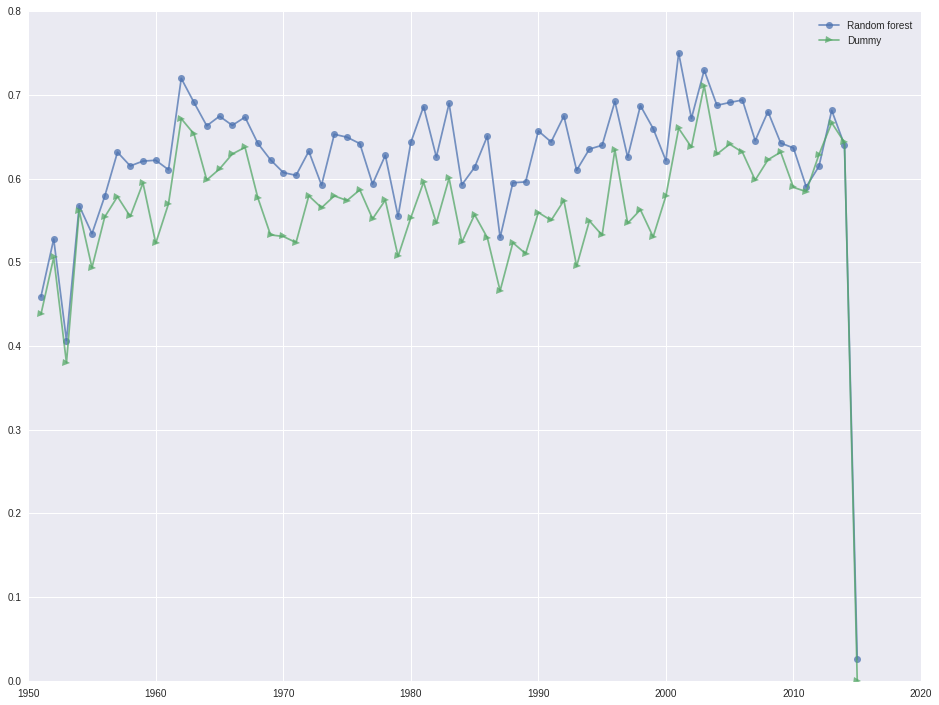

In [35]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

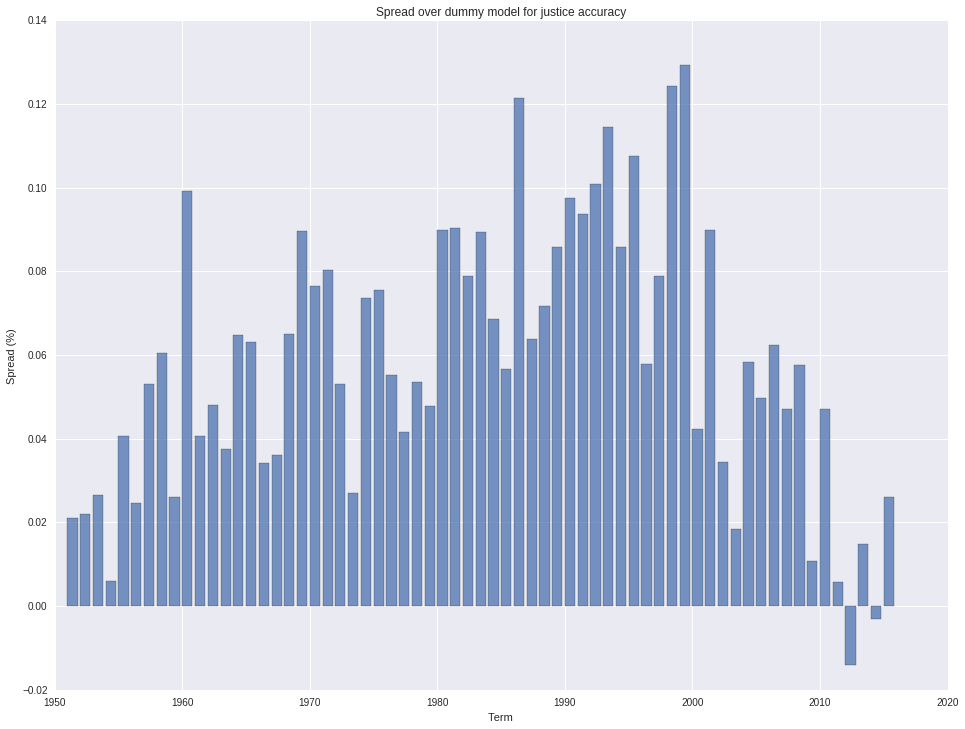

In [36]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [37]:
# Feature importance
feature_importance_df = pandas.DataFrame(zip(feature_df.columns, m.feature_importances_),
                                         columns=["feature", "importance"])
feature_importance_df.sort("importance", ascending=False).head(20)

/data/workspace/ipython/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
1367,justice_cumulative_lc_direction_diff,0.020545
1366,justice_previous_lc_direction_diff,0.020275
1361,justice_cumulative_agreement,0.016418
1360,justice_previous_agreement,0.015976
1349,justice_cumulative_direction,0.015596
1353,justice_cumulative_court_direction_diff,0.015521
1348,justice_previous_direction,0.015489
1352,justice_previous_court_direction_diff,0.015486
1156,issue_area_9,0.015196
1354,justice_previous_action,0.014575


In [38]:
import statsmodels.stats.proportion

In [39]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=14.625360103601805, pvalue=4.418880998420542e-22)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=5.538677329912395, pvalue=3.0476455848880839e-08)
Binomial:
4.38283243876e-242


## Case Outcomes

In [40]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

In [41]:
# Set DFs
rf_predicted_case = raw_data[["docketId", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [42]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = raw_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted_case"]

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.89      0.49      0.63      3676
        0.0       0.53      0.22      0.31     21597
        1.0       0.69      0.90      0.78     45782

avg / total       0.65      0.68      0.63     71055

[[ 1794    63  1819]
 [   89  4817 16691]
 [  126  4274 41382]]
0.675434522553

Dummy model
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00      3676
        0.0       0.00      0.00      0.00     21597
        1.0       0.64      1.00      0.78     45782

avg / total       0.42      0.64      0.50     71055

[[    0     0  3676]
 [    0     0 21597]
 [    0     0 45782]]
0.644317782



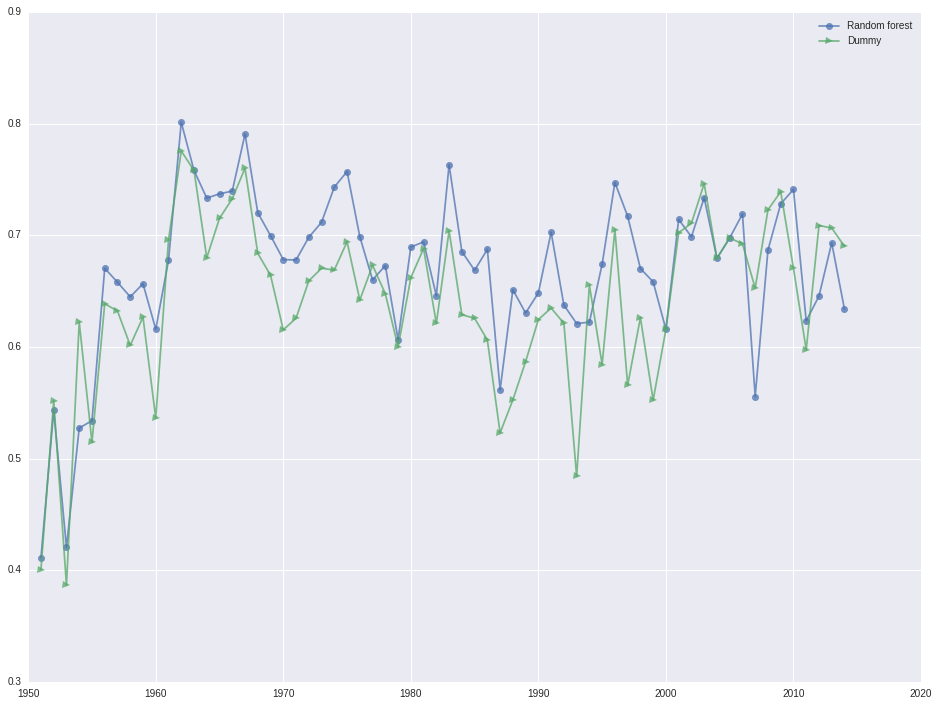

In [43]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

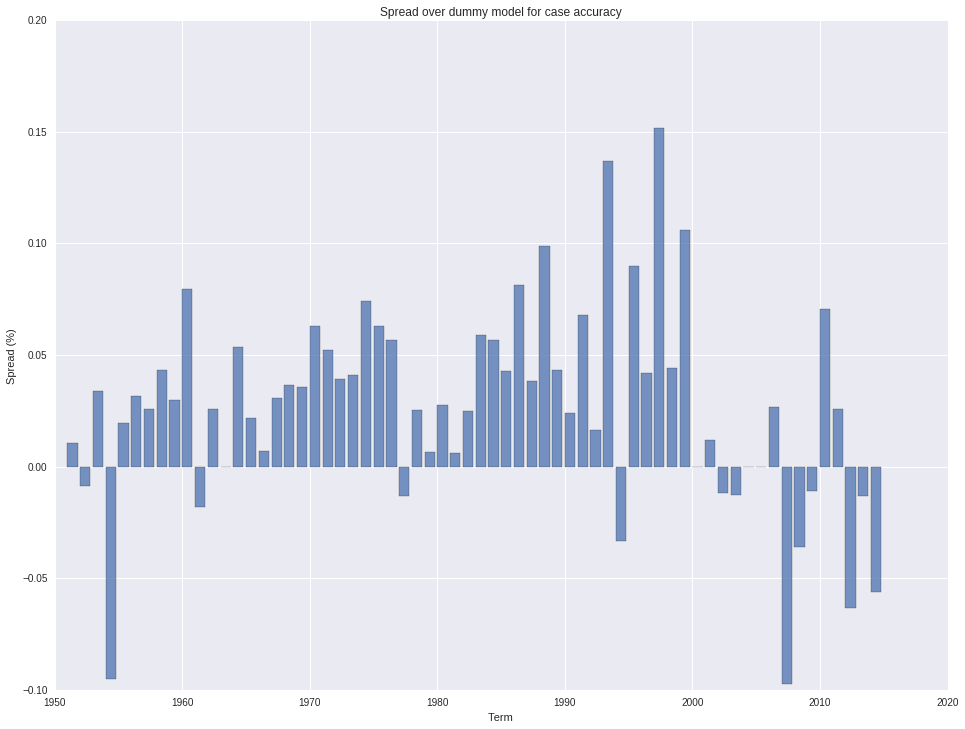

In [44]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

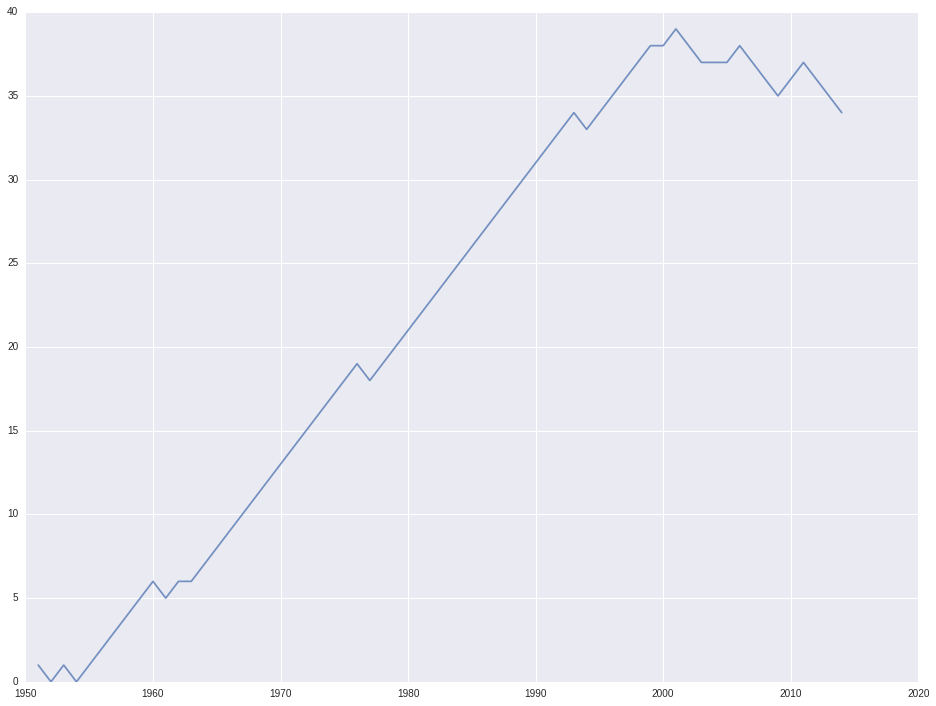

In [45]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [46]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct_case"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct_case"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=4.7181662623237575, pvalue=1.3661043550455556e-05)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.292244135311964, pvalue=0.021891559458295004)
Binomial:
1.92752581765e-68


In [47]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,22281,22282,22283,22284,22285,22286,22287,22288,22289
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,1,1,0,0
rf_predicted_score_affirm,0.646543,0.1625,0.1125,0.495,0.2275,0.3325,0.1825,0.5475,0.545
rf_predicted_score_reverse,0.330957,0.805,0.855,0.4825,0.7275,0.6225,0.78,0.4325,0.4175
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [48]:
raw_data.loc[raw_data.loc[:, "caseName"] == "OBERGEFELL v. HODGES", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,77288,77289,77290,77291,77292,77293,77294,77295,77296
caseName,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,0,1,0,1,1,0,1,1
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.281884,0.321014,0.295652,0.333333,0.268116,0.263768,0.313768,0.272464,0.262319
rf_predicted_score_reverse,0.702899,0.671014,0.688406,0.65942,0.724638,0.725362,0.676812,0.716667,0.728986
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [49]:
raw_data.loc[raw_data.loc[:, "caseName"] == "KING v. BURWELL", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,77126,77127,77128,77129,77130,77131,77132,77133,77134
caseName,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,0,1,0,1,0,0,1,0,0
rf_predicted,0,0,0,0,0,0,0,0,0
rf_predicted_score_affirm,0.599003,0.570018,0.593931,0.563496,0.625271,0.629166,0.569293,0.633242,0.621195
rf_predicted_score_reverse,0.385779,0.415489,0.390127,0.422736,0.354439,0.352718,0.418388,0.350091,0.363587
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [50]:
raw_data.loc[raw_data.loc[:, "caseName"] == 'CITIZENS UNITED v. FEDERAL ELECTION COMMISSION',
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,73130,73131,73132,73133,73134,73135,73136,73137,73138
caseName,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION
justiceName,JGRoberts,JPStevens,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,1,0,1,1,1,0,0,1,0
rf_predicted,1,0,1,1,1,0,0,1,1
rf_predicted_score_affirm,0.40986,0.576562,0.410641,0.406735,0.393454,0.555469,0.513281,0.400485,0.382812
rf_predicted_score_reverse,0.569046,0.377344,0.560453,0.55889,0.572953,0.410156,0.453906,0.576078,0.464844
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [51]:
raw_data.loc[raw_data.loc[:, "caseName"] == 'DISTRICT OF COLUMBIA v. HELLER',
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,72257,72258,72259,72260,72261,72262,72263,72264,72265
caseName,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER
justiceName,JPStevens,AScalia,AMKennedy,DHSouter,CThomas,RBGinsburg,SGBreyer,JGRoberts,SAAlito
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,1,0,0,1,0,1,1,0,0
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.441935,0.387097,0.350806,0.398387,0.372581,0.437903,0.406452,0.368548,0.371774
rf_predicted_score_reverse,0.529839,0.595161,0.628226,0.587903,0.605645,0.545968,0.579032,0.61371,0.614516
rf_correct_case,0,0,0,0,0,0,0,0,0
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [52]:
raw_data["rf_predicted"].value_counts(normalize=True)

 1    0.727917
 0    0.165477
-1    0.040290
Name: rf_predicted, dtype: float64

In [53]:
raw_data.tail()

,adminAction,adminActionState,authorityDecision1,authorityDecision2,caseDisposition,caseDispositionUnusual,caseId,caseIssuesId,caseName,caseOrigin,...,rf_predicted_score_other,rf_predicted_score_affirm,rf_predicted_score_reverse,dummy_predicted,rf_correct,dummy_correct,rf_predicted_case,dummy_predicted_case,rf_correct_case,dummy_correct_case
78030,NaN,NaN,NaN,NaN,NaN,NaN,2015-077,2015-077,Nichols v. United States,72,...,0.005714,0.447857,0.546429,1,0,0,0,1,NaN,NaN
78031,NaN,NaN,NaN,NaN,NaN,NaN,2015-077,2015-077,Nichols v. United States,72,...,0.008571,0.432143,0.559286,1,0,0,0,1,NaN,NaN
78032,NaN,NaN,NaN,NaN,NaN,NaN,2015-077,2015-077,Nichols v. United States,72,...,0.015000,0.555714,0.429286,1,0,0,0,1,NaN,NaN
78033,NaN,NaN,NaN,NaN,NaN,NaN,2015-077,2015-077,Nichols v. United States,72,...,0.008571,0.453571,0.537857,1,0,0,0,1,NaN,NaN
78034,NaN,NaN,NaN,NaN,NaN,NaN,2015-077,2015-077,Nichols v. United States,72,...,0.005714,0.448571,0.545714,1,0,0,0,1,NaN,NaN


In [54]:
# Write output
import cPickle as pickle
import time

timestamp_suffix = time.strftime("%Y%m%d%H%M%S")
raw_data.to_csv("data/output/fantayscotus_2015_build_scdb_model_40_{0}.csv".format(timestamp_suffix),
                 index=False)
# You probably don't want to do this, as the object can be tens of GB
#pickle.dump(m, open("scotus_scdb_model_{0}.pickle".format(timestamp_suffix), "w"))

In [55]:
raw_data.loc[raw_data["term"] == 2015,
             ["caseName", "docket", "justice", "justiceName", "rf_predicted", "rf_predicted_case", "rf_predicted_score_reverse", "rf_predicted_score_affirm"]]\
    .to_csv("fantayscotus_2015_build_scdb_model_40_{0}.csv".format(timestamp_suffix))

0.371561244597
0.417417417417


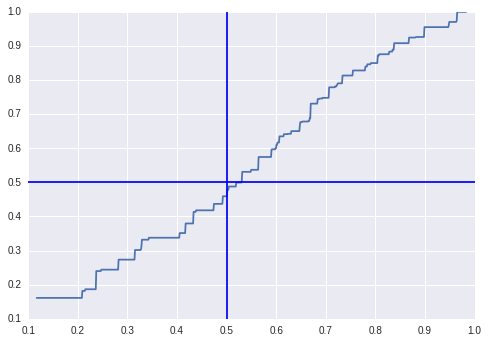

In [56]:
import sklearn.isotonic
import sklearn.calibration

calibrator = sklearn.isotonic.IsotonicRegression()
calibration_mask = -raw_data["rf_predicted_score_reverse"].isnull() & raw_data["justice_outcome_disposition"].isin([0, 1])
input_score = raw_data.loc[calibration_mask, "rf_predicted_score_reverse"] / (raw_data.loc[calibration_mask, "rf_predicted_score_reverse"] + raw_data.loc[calibration_mask, "rf_predicted_score_affirm"])
input_target = raw_data.loc[calibration_mask, "justice_outcome_disposition"]
calibrator.fit(input_score, input_target)

x = numpy.linspace(0, 1, 1000)
y = calibrator.predict(x)
plt.plot(x, y)
plt.axhline(0.5)
plt.axvline(0.5)
cutoff = 1 - input_target.mean()
print(cutoff)
threshold = x[numpy.where(y >= cutoff)][0]
print(threshold)